In [34]:
import numpy as np
! pip install sklearn-pandas
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

! pip install torchtuples
import torch
import torchtuples as tt

! pip install pycox
# from pycox.datasets import metabric
# from pycox.datasets import metabric
from pycox.models import MTLR
from pycox.evaluation import EvalSurv

In [35]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [36]:
def f_get_Normalization(X, norm_mode):    
    num_Patient, num_Feature = np.shape(X)
    
    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.nanstd(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))/np.nanstd(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.nanmean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.nanmin(X[:,j]))/(np.nanmax(X[:,j]) - np.nanmin(X[:,j]))
    else:
        print("INPUT MODE ERROR!")
    
    return X


def f_get_fc_mask1(meas_time, num_Event, num_Category):
    '''
        mask3 is required to get the contional probability (to calculate the denominator part)
        mask3 size is [N, num_Event, num_Category]. 1's until the last measurement time
    '''
    mask = np.zeros([np.shape(meas_time)[0], num_Event, num_Category]) # for denominator
    for i in range(np.shape(meas_time)[0]):
        mask[i, :, :int(meas_time[i, 0]+1)] = 1 # last measurement time

    return mask


def f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask4 is required to get the log-likelihood loss 
        mask4 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    mask = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask


def f_get_fc_mask3(time, meas_time, num_Category):
    '''
        mask5 is required calculate the ranking loss (for pair-wise comparision)
        mask5 size is [N, num_Category]. 
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    if np.shape(meas_time):  #lonogitudinal measurements 
        for i in range(np.shape(time)[0]):
            t1 = int(meas_time[i, 0]) # last measurement time
            t2 = int(time[i, 0]) # censoring/event time
            mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    else:                    #single measurement
        for i in range(np.shape(time)[0]):
            t = int(time[i, 0]) # censoring/event time
            mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
    return mask



##### TRANSFORMING DATA
def f_construct_dataset(df, feat_list):
    '''
        id   : patient indicator
        tte  : time-to-event or time-to-censoring
            - must be synchronized based on the reference time
        times: time at which observations are measured
            - must be synchronized based on the reference time (i.e., times start from 0)
        label: event/censoring information
            - 0: censoring
            - 1: event type 1
            - 2: event type 2
            ...
    '''

    grouped  = df.groupby(['id'])
    id_list  = pd.unique(df['id'])
    max_meas = np.max(grouped.count())[0]

    data     = np.zeros([len(id_list), max_meas, len(feat_list)+1])
    pat_info = np.zeros([len(id_list), 5])

    for i, tmp_id in enumerate(id_list):
        tmp = grouped.get_group(tmp_id).reset_index(drop=True)

        pat_info[i,4] = tmp.shape[0]                                   #number of measurement
        pat_info[i,3] = np.max(tmp['times'])     #last measurement time
        pat_info[i,2] = tmp['label'][0]      #cause
        pat_info[i,1] = tmp['tte'][0]         #time_to_event
        pat_info[i,0] = tmp['id'][0]      

        data[i, :int(pat_info[i, 4]), 1:]  = tmp[feat_list]
        data[i, :int(pat_info[i, 4]-1), 0] = np.diff(tmp['times'])
    
    return pat_info, data


def import_dataset(norm_mode = 'standard'):

    df_                = pd.read_csv('pbc2_cleaned.csv')

    bin_list           = ['drug', 'sex', 'ascites', 'hepatomegaly', 'spiders']
    cont_list          = ['age', 'edema', 'serBilir', 'serChol', 'albumin', 'alkaline', 'SGOT', 'platelets', 'prothrombin', 'histologic']
    feat_list          = cont_list + bin_list
    df_                = df_[['id', 'tte', 'times', 'label']+feat_list]
    df_org_            = df_.copy(deep=True)

    df_[cont_list]     = f_get_Normalization(np.asarray(df_[cont_list]).astype(float), norm_mode)

    pat_info, data     = f_construct_dataset(df_, feat_list)
    _, data_org        = f_construct_dataset(df_org_, feat_list)

    data_mi                  = np.zeros(np.shape(data))
    data_mi[np.isnan(data)]  = 1
    data_org[np.isnan(data)] = 0
    data[np.isnan(data)]     = 0 

    x_dim           = np.shape(data)[2] # 1 + x_dim_cont + x_dim_bin (including delta)
    x_dim_cont      = len(cont_list)
    x_dim_bin       = len(bin_list) 

    last_meas       = pat_info[:,[3]]  #pat_info[:, 3] contains age at the last measurement
    label           = pat_info[:,[2]]  #two competing risks
    time            = pat_info[:,[1]]  #age when event occurred

    num_Category    = int(np.max(pat_info[:, 1]) * 1.2) #or specifically define larger than the max tte
    num_Event       = len(np.unique(label)) - 1

    if num_Event == 1:
        label[np.where(label!=0)] = 1 #make single risk

    mask1           = f_get_fc_mask1(last_meas, num_Event, num_Category)
    mask2           = f_get_fc_mask2(time, label, num_Event, num_Category)
    mask3           = f_get_fc_mask3(time, -1, num_Category)

    DIM             = (x_dim, x_dim_cont, x_dim_bin)
    DATA            = (data, time, label)
    # DATA            = (data, data_org, time, label)
    MASK            = (mask1, mask2, mask3)

    return DIM, DATA, MASK, data_mi

In [37]:
df = pd.read_csv('pbc2_cleaned.csv')

DIM, DATA, MASK, data_mi = import_dataset()

In [38]:
labels = np.reshape(DATA[2],-1)
time = np.reshape(DATA[1],-1)
for i in range(312):
  if labels[i] == 2:
    labels[i] = 0

features = np.zeros([312,256])

for id in range(312):
    features[id] = np.reshape(DATA[0][id],-1)

In [39]:
X = pd.DataFrame(features)

In [40]:
X['duration'] = time
X['event'] = labels

In [41]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,duration,event
0,28.0,0.944976,2.581683,2.015877,-0.356880,-1.570646,0.281173,0.195488,-0.447383,0.813132,0.841936,1.0,0.0,1.0,1.0,1.0,0.0,0.944976,2.581683,3.281890,0.0,-0.894575,0.192493,-1.485263,-0.519077,0.136768,0.841936,1.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,1.0
1,26.0,0.714442,-0.575421,-0.478914,-0.110845,1.491559,5.030580,-0.116943,-0.129880,-0.269050,-0.304016,1.0,0.0,0.0,1.0,1.0,26.0,0.714442,-0.575421,-0.534768,0.0,0.417798,0.606612,0.214616,-0.467867,0.001495,-0.304016,1.0,0.0,0.0,1.0,1.0,58.0,0.714442,-0.575421,-0.497532,0.000000,0.318376,0.275317,0.274552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,736.0,0.0
2,26.0,2.069065,1.003131,-0.423061,-0.866954,0.179185,-0.724426,-0.338833,-0.846822,0.677859,0.841936,1.0,1.0,0.0,0.0,0.0,26.0,2.069065,-0.575421,-0.478914,0.0,-0.198620,-0.860793,-0.674218,-0.754643,0.677859,0.841936,1.0,1.0,0.0,1.0,1.0,54.0,2.069065,1.003131,-0.404443,-0.524905,0.358145,-0.973735,-0.832346,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,1.0
3,27.0,0.544876,1.003131,-0.348589,-0.458895,-1.689953,3.965582,-0.791539,-0.519077,-0.471960,0.841936,1.0,0.0,0.0,1.0,1.0,26.0,0.544876,1.003131,-0.385825,0.0,-1.013882,-0.173104,0.590808,0.064718,5.412408,0.841936,1.0,0.0,0.0,1.0,1.0,51.0,0.544876,1.003131,-0.367207,0.000000,-1.172958,-0.188162,0.551276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,275.0,1.0
4,29.0,-1.108870,-0.575421,-0.050704,-0.248865,0.278607,-0.594753,-0.120769,-1.000452,-0.066141,-0.304016,0.0,0.0,0.0,1.0,1.0,27.0,-1.108870,-0.575421,-0.329971,0.0,-0.218504,-0.579694,-0.239365,-1.225776,-0.201414,-0.304016,0.0,0.0,0.0,1.0,0.0,54.0,-1.108870,1.003131,-0.218264,0.000000,-0.099197,-0.610648,-0.062109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215.0,0.0


In [42]:
df_train = X

df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
df_all = X

In [43]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,duration,event
0,28.0,0.944976,2.581683,2.015877,-0.356880,-1.570646,0.281173,0.195488,-0.447383,0.813132,0.841936,1.0,0.0,1.0,1.0,1.0,0.0,0.944976,2.581683,3.281890,0.0,-0.894575,0.192493,-1.485263,-0.519077,0.136768,0.841936,1.0,0.0,1.0,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,1.0
1,26.0,0.714442,-0.575421,-0.478914,-0.110845,1.491559,5.030580,-0.116943,-0.129880,-0.269050,-0.304016,1.0,0.0,0.0,1.0,1.0,26.0,0.714442,-0.575421,-0.534768,0.0,0.417798,0.606612,0.214616,-0.467867,0.001495,-0.304016,1.0,0.0,0.0,1.0,1.0,58.0,0.714442,-0.575421,-0.497532,0.000000,0.318376,0.275317,0.274552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,736.0,0.0
2,26.0,2.069065,1.003131,-0.423061,-0.866954,0.179185,-0.724426,-0.338833,-0.846822,0.677859,0.841936,1.0,1.0,0.0,0.0,0.0,26.0,2.069065,-0.575421,-0.478914,0.0,-0.198620,-0.860793,-0.674218,-0.754643,0.677859,0.841936,1.0,1.0,0.0,1.0,1.0,54.0,2.069065,1.003131,-0.404443,-0.524905,0.358145,-0.973735,-0.832346,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,1.0
3,27.0,0.544876,1.003131,-0.348589,-0.458895,-1.689953,3.965582,-0.791539,-0.519077,-0.471960,0.841936,1.0,0.0,0.0,1.0,1.0,26.0,0.544876,1.003131,-0.385825,0.0,-1.013882,-0.173104,0.590808,0.064718,5.412408,0.841936,1.0,0.0,0.0,1.0,1.0,51.0,0.544876,1.003131,-0.367207,0.000000,-1.172958,-0.188162,0.551276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,275.0,1.0
4,29.0,-1.108870,-0.575421,-0.050704,-0.248865,0.278607,-0.594753,-0.120769,-1.000452,-0.066141,-0.304016,0.0,0.0,0.0,1.0,1.0,27.0,-1.108870,-0.575421,-0.329971,0.0,-0.218504,-0.579694,-0.239365,-1.225776,-0.201414,-0.304016,0.0,0.0,0.0,1.0,0.0,54.0,-1.108870,1.003131,-0.218264,0.000000,-0.099197,-0.610648,-0.062109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,215.0,0.0


In [44]:
df_train.columns

Index([         0,          1,          2,          3,          4,          5,
                6,          7,          8,          9,
       ...
              248,        249,        250,        251,        252,        253,
              254,        255, 'duration',    'event'],
      dtype='object', length=258)

In [45]:
cols_standardize = []
cols_leave = []
for i in df_train.columns[:-2]:
  if i%16 < 11 and i%16 > 0:
    cols_standardize.append(i)

  else:
    cols_leave.append(i)


standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [46]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')
x_all = x_mapper.transform(df_all).astype('float32')

In [47]:
event_time = [  8.,  11.,  16.,  20.,  26.,  27.,  29.,  30.,  31.,  32.,  38.,
        44.,  47.,  50.,  56.,  74.,  76.,  79.,  89.,  96.,  99., 101.,
       105., 109., 112., 114., 118., 120., 122., 125., 127., 129., 133.,
       134., 135., 139., 143., 145., 148., 152., 154., 155., 165., 166.,
       167., 170., 173., 185., 186., 193., 194., 201., 204., 205., 206.,
       213., 215., 219., 220., 235., 236., 239., 241., 248., 255., 261.,
       263., 264., 267., 271., 275., 278., 285., 287., 292., 293., 297.,
       298., 303., 317., 322., 328., 332., 335., 336., 340., 345., 353.,
       357., 362., 364., 368., 370., 395., 399., 411., 438., 440., 441.,
       459., 462., 468., 482., 484., 489., 491., 511., 525., 536., 547.,
       549., 556., 597.]
np.shape(event_time)   

(113,)

In [48]:

labtrans = MTLR.label_transform(event_time)
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)


/usr/local/lib/python3.7/dist-packages/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")


In [49]:
type(labtrans)


pycox.preprocessing.label_transforms.LabTransDiscreteTime

In [50]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)


In [51]:
model = MTLR(net, tt.optim.Adam, duration_index=labtrans.cuts)


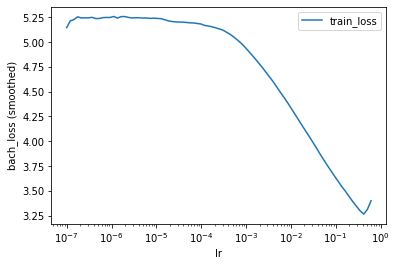

In [52]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=6)
_ = lr_finder.plot()

In [53]:
lr_finder.get_best_lr()


0.04229242874389523

In [54]:
model.optimizer.set_lr(0.01)
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)


0:	[0s / 0s],		train_loss: 5.4789,	val_loss: 8.1949
1:	[0s / 0s],		train_loss: 3.8986,	val_loss: 6.9791
2:	[0s / 0s],		train_loss: 3.2219,	val_loss: 5.7194
3:	[0s / 0s],		train_loss: 2.8356,	val_loss: 5.0471
4:	[0s / 0s],		train_loss: 2.4501,	val_loss: 4.5633
5:	[0s / 0s],		train_loss: 2.3923,	val_loss: 4.1232
6:	[0s / 0s],		train_loss: 2.3024,	val_loss: 3.8870
7:	[0s / 0s],		train_loss: 2.1157,	val_loss: 3.6992
8:	[0s / 0s],		train_loss: 2.0224,	val_loss: 3.5712
9:	[0s / 0s],		train_loss: 1.8400,	val_loss: 3.4123
10:	[0s / 0s],		train_loss: 1.9416,	val_loss: 3.1260
11:	[0s / 0s],		train_loss: 1.7702,	val_loss: 2.9353
12:	[0s / 0s],		train_loss: 1.6970,	val_loss: 2.8269
13:	[0s / 0s],		train_loss: 1.6999,	val_loss: 2.7746
14:	[0s / 0s],		train_loss: 1.6956,	val_loss: 2.7514
15:	[0s / 0s],		train_loss: 1.5453,	val_loss: 2.7461
16:	[0s / 0s],		train_loss: 1.4646,	val_loss: 2.7899
17:	[0s / 0s],		train_loss: 1.5295,	val_loss: 2.8293
18:	[0s / 0s],		train_loss: 1.4772,	val_loss: 2.8664
19:

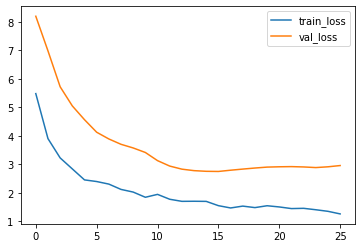

In [55]:
_ = log.plot()

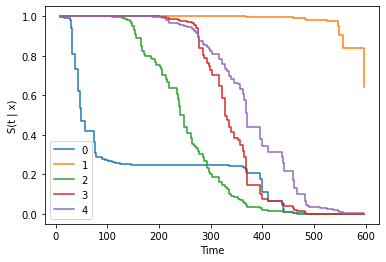

In [56]:
surv = model.predict_surv_df(x_all)

surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [57]:
surv

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311
8.0,0.997260,1.000000,1.000000,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,0.868601,1.000000,0.997130,1.000000,0.998633,1.000000,1.000000,0.999111,0.854867,1.000000,1.000000e+00,0.999997,0.997378,9.982545e-01,1.000000,1.000000,0.999999,0.877758,0.999896,1.000000,9.997242e-01,1.000000,1.000000,1.000000,1.000000,0.999998,1.000000,9.966398e-01,1.000000,1.000000,1.000000,...,0.999756,1.000000,1.000000,0.999922,1.000000,0.999805,1.000000,1.000000,0.890981,1.000000,0.999999,1.000000,0.999958,0.999049,1.000000,0.999895,1.000000,0.999999,0.999999,1.000000e+00,0.998577,1.000000,0.999985,0.999843,0.998301,0.999955,0.963679,0.995705,0.999982,1.000000,1.000000e+00,0.999664,1.000000,0.999957,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
11.0,0.995699,1.000000,1.000000,1.000000,0.999997,1.000000,1.000000,1.000000,1.000000,0.785094,0.999999,0.995297,1.000000,0.997385,1.000000,1.000000,0.998699,0.768511,1.000000,1.000000e+00,0.999994,0.996120,9.971331e-01,1.000000,1.000000,0.999997,0.796663,0.999836,1.000000,9.995516e-01,1.000000,1.000000,1.000000,1.000000,0.999996,1.000000,9.946793e-01,1.000000,1.000000,1.000000,...,0.999657,1.000000,1.000000,0.999868,1.000000,0.999619,1.000000,0.999999,0.833402,1.000000,0.999997,1.000000,0.999925,0.998495,1.000000,0.999831,1.000000,0.999998,0.999998,1.000000e+00,0.997734,1.000000,0.999975,0.999775,0.997388,0.999936,0.939582,0.992847,0.999973,1.000000,1.000000e+00,0.999398,1.000000,0.999927,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
16.0,0.993598,1.000000,1.000000,0.999999,0.999994,1.000000,0.999999,1.000000,1.000000,0.720269,0.999999,0.992562,1.000000,0.995391,0.999999,1.000000,0.998219,0.700317,1.000000,1.000000e+00,0.999989,0.994973,9.955467e-01,1.000000,1.000000,0.999993,0.734241,0.999763,1.000000,9.993073e-01,1.000000,1.000000,1.000000,1.000000,0.999993,1.000000,9.922897e-01,1.000000,1.000000,1.000000,...,0.999556,1.000000,1.000000,0.999778,1.000000,0.999374,1.000000,0.999998,0.788310,1.000000,0.999995,0.999999,0.999895,0.997696,1.000000,0.999724,1.000000,0.999995,0.999996,1.000000e+00,0.996480,1.000000,0.999957,0.999717,0.996493,0.999918,0.920114,0.989018,0.999964,1.000000,1.000000e+00,0.999176,1.000000,0.999881,1.000000,1.000000,1.000000,1.000000,1.000000,0.999999
20.0,0.991393,1.000000,1.000000,0.999999,0.999991,1.000000,0.999999,1.000000,1.000000,0.593787,0.999999,0.989550,1.000000,0.993865,0.999999,1.000000,0.997436,0.565064,1.000000,1.000000e+00,0.999986,0.992571,9.931583e-01,1.000000,1.000000,0.999990,0.613740,0.999576,1.000000,9.987218e-01,1.000000,1.000000,1.000000,1.000000,0.999990,1.000000,9.887884e-01,1.000000,1.000000,1.000000,...,0.999381,1.000000,1.000000,0.999689,1.000000,0.999089,0.999999,0.999996,0.705718,1.000000,0.999993,0.999999,0.999846,0.996877,1.000000,0.999618,1.000000,0.999993,0.999994,1.000000e+00,0.995297,1.000000,0.999941,0.999607,0.994522,0.999886,0.880749,0.983828,0.999950,1.000000,1.000000e+00,0.998739,1.000000,0.999830,1.000000,1.000000,1.000000,1.000000,1.000000,0.999998
26.0,0.988831,1.000000,0.999999,0.999999,0.999989,1.000000,0.999999,1.000000,1.000000,0.531104,0.999998,0.985904,1.000000,0.992992,0.999998,1.000000,0.996297,0.499272,1.000000,1.000000e+00,0.999983,0.989100,9.905971e-01,1.000000,1.000000,0.999988,0.549505,0.999312,1.000000,9.980342e-01,1.000000,1.000000,1.000000,1.000000,0.999986,1.000000,9.849830e-01,1.000000,1.000000,1.000000,...,0.999111,1.000000,1.000000,0.999573,1.000000,0.998820,0.999999,0.999996,0.651622,1.000000,0.999990,0.999998,0.999815,0.995744,0.999999,0.999473,1.000000,0.999991,0.999991,1.000000e+00,0.993769,1.000000,0.999920,0.999426,0.991240,0.999838,0.858649,0.977172,0.999921,1.000000,1.000000e+00,0.998484,1.000000,0.999763,1.000000,1.0000

In [58]:
mltr_predictions = {}

for patient in range(312):
  surv_data = np.zeros(113)
  i = 0
  for t in event_time:
    surv_data[i] = surv[patient][t]
    i += 1
  mltr_predictions[patient] = surv_data

In [59]:
mltr_predictions[0]

array([9.97259676e-01, 9.95699167e-01, 9.93598342e-01, 9.91392970e-01,
       9.88831282e-01, 9.79101777e-01, 9.60589170e-01, 9.40369010e-01,
       8.89251709e-01, 8.08831096e-01, 7.32518315e-01, 6.19525909e-01,
       5.37263393e-01, 4.71540511e-01, 4.17416096e-01, 3.66329908e-01,
       3.09064806e-01, 2.88543344e-01, 2.77478814e-01, 2.74558127e-01,
       2.70984709e-01, 2.68900216e-01, 2.66913354e-01, 2.64714897e-01,
       2.61904061e-01, 2.59529293e-01, 2.58307993e-01, 2.57380426e-01,
       2.55494475e-01, 2.54797876e-01, 2.54047811e-01, 2.53134429e-01,
       2.52303958e-01, 2.51756847e-01, 2.51283348e-01, 2.50743032e-01,
       2.50111341e-01, 2.49720454e-01, 2.49465704e-01, 2.49119580e-01,
       2.48927951e-01, 2.48812437e-01, 2.48639464e-01, 2.48580337e-01,
       2.48477757e-01, 2.48343289e-01, 2.48311281e-01, 2.48236775e-01,
       2.48198986e-01, 2.48182416e-01, 2.48155296e-01, 2.48149097e-01,
       2.48145461e-01, 2.48135149e-01, 2.48126745e-01, 2.48122811e-01,
      

In [60]:
import pickle
pickle.dump( mltr_predictions, open( "mltr.p", "wb" ) )